<a href="https://colab.research.google.com/github/pgssanjana/micro_projects/blob/main/test_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
train_dataset_path = '/content/gdrive/MyDrive/gsoc/model1/train/'
validation_dataset_path = '/content/gdrive/MyDrive/gsoc/model1/test/'

In [7]:
img=cv2.imread('/content/gdrive/MyDrive/gsoc/model1/train/prep-img/frame0.jpg')
img.shape

(480, 854, 3)

In [8]:
IMG_WIDTH = 480
IMG_HEIGHT = 854
BATCH_SIZE = 32

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2255 images belonging to 5 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 379 images belonging to 5 classes.


In [11]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : cleaning-coag-imgs
1 : clipping-cutting-imgs
2 : galbladder-disc-img
3 : galbladder-pack-imgs
4 : prep-img


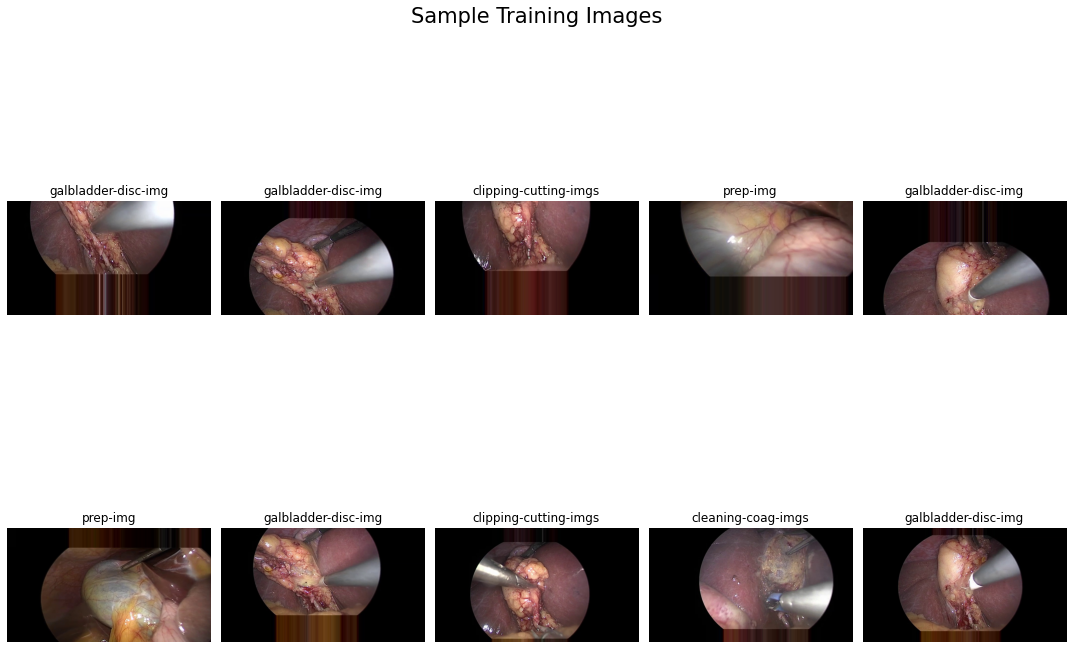

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


In [13]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])
    
    return model

In [14]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 476, 850, 128)     9728      
                                                                 
 activation (Activation)     (None, 476, 850, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 238, 425, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 238, 425, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 423, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 236, 423, 64)      0

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [16]:
x,y=validation_generator.next()
x.shape


(32, 480, 854, 3)

In [17]:
import tensorflow as tf
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                              monitor='val_loss',
                             verbose=1, 
                             save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model=ResNet50(include_top=False,weights='imagenet',input_shape=(480,854,3))

av1=GlobalAveragePooling2D()(base_model.output)
fc1 = Dense(256,activation='relu')(av1)
fc2=Dense(5,activation='sigmoid')(fc1)

model_new=Model(inputs=base_model.input,outputs=fc2)

for layer in base_model.layers:
  layer.trainable=False

adam=Adam(learning_rate=0.00003)
model_new.compile(optimizer=Adam(lr=0.003),metrics=['accuracy'],loss='binary_crossentropy')

History = model_new.fit(train_generator,validation_data=validation_generator,epochs=10,verbose=1,callbacks=my_callbacks,steps_per_epoch=32)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.2051
Epoch 1: val_loss improved from inf to 0.51160, saving model to model.01-0.51.h5
32/32 [==============================] - 354s 11s/step - loss: 0.8348 - accuracy: 0.2051 - val_loss: 0.5116 - val_accuracy: 0.1979
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.2661
Epoch 2: val_loss improved from 0.51160 to 0.49328, saving model to model.02-0.49.h5
32/32 [==============================] - 185s 6s/step - loss: 0.5053 - accuracy: 0.2661 - val_loss: 0.4933 - val_accuracy: 0.5937
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.3833
Epoch 3: val_loss improved from 0.49328 to 0.46115, saving model to model.03-0.46.h5
32/32 [==============================] - 148s 5s/step - loss: 0.4731 - accuracy: 0.3833 - val_loss: 0.4612 - val_accuracy: 0.3773
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.4637 -

12/12 [==============================] - 11s 770ms/step


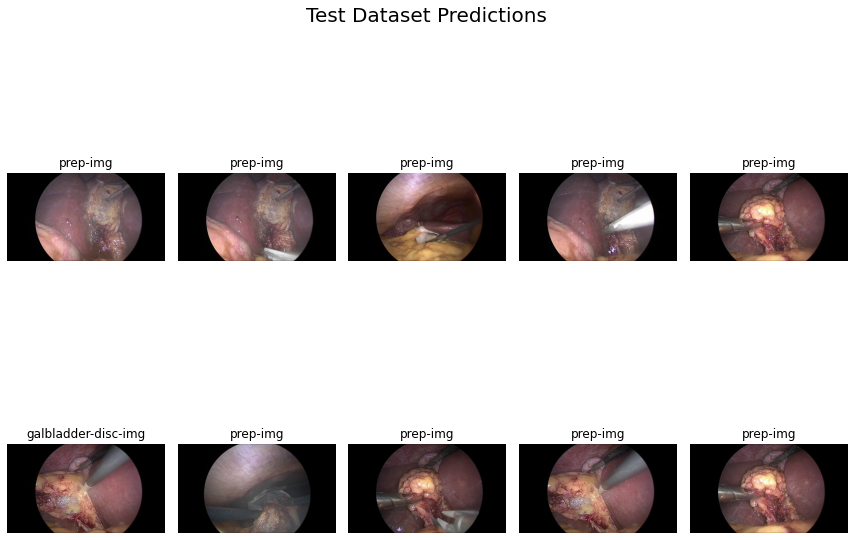

In [19]:
predictions = model_new.predict(validation_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator[4][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [20]:
# loading library
import pickle
# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as files:
    pickle.dump(model_new, files)

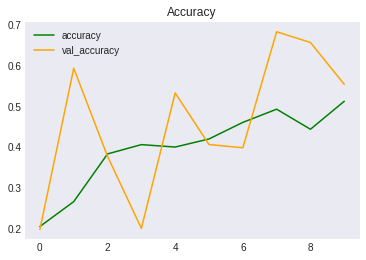

In [22]:
import ctypes
# ctypes.cast(0x7ffa1bb2e650,ctypes.py_object).value
# history = ctypes.cast(0x7ffa1bb2e650,ctypes.py_object).value
plt.style.use("seaborn-dark")
plt.title("Accuracy")
plt.plot(History.history['accuracy'],label="accuracy",c='green')
plt.plot(History.history['val_accuracy'],label="val_accuracy",c='orange')
plt.legend()
plt.show()
# history

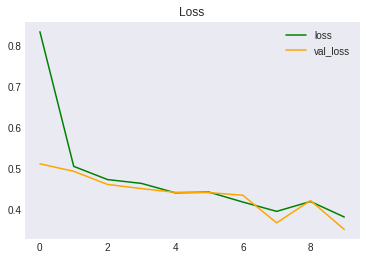

In [23]:
plt.style.use("seaborn-dark")
plt.title("Loss")
plt.plot(History.history['loss'],label="loss",c='green')
plt.plot(History.history['val_loss'],label="val_loss",c='orange')
plt.legend()
plt.show()